# Compare and make Predictor of Proliferative outliers

In [ ]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model

# prediction stuff

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report,f1_score,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error



# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-16 14:19:01.528831: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 14:19:01.529281: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 14:19:01.531721: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 14:19:01.537709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737062341.547088 3782650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737062341.54

ModuleNotFoundError: No module named 'rc_context'

In [2]:
## parameters
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"
res_id = "cellType" # cellType subtype celltype_granular

curr_treatment = "drug"


pseudobulk_ids = ["GSE192898", "GSE154600", "GSE180661", "GSE217517", "GSE165897"]

tumor_cell_ids = ['Tumor_cell', "Epithelial cells", "Ovarian.cancer.cell",
                  "EOC"]

immune_cell_ids = ['B-cell', 'CD4+_T-cell',  'CD8+_T-cell', 'Macrophage',
                    'Monocyte', 'NK_cell', "CD8+ T-cells", "Macrophages", "Monocytes", 
                    "NK cells", "CD4+ T-cells", "B-cells",
                    "T.cell", "Monocyte", "B.cell", "Immune"]
stromal_cell_ids = ['Endothelial_cell', 'Fibroblast', "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Endothelial.cell", "Stromal"]



In [3]:
# load each pseudobulk

all_adata = None
for curr_pseudobulk_id in pseudobulk_ids:

    # set file names
    sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/{curr_pseudobulk_id}_pseudobulks/"
    in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"
    subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"

    # read
    adata = sc.read_h5ad(in_ad_file)
    subtype_df = pd.read_csv(subtype_file, sep="\t")

    # append to obs they should be in exactly the same order
    subtype_df.index = adata.obs.index
    adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

    # make cell type annotations
    if curr_pseudobulk_id == "GSE192898":
        cell_types = ['B-cell',
                        'CD4+_T-cell',
                        'CD8+_T-cell',
                        'Endothelial_cell',
                        'Fibroblast',
                        'Macrophage',
                        'Monocyte',
                        'NK_cell',
                        'Tumor_cell']
    elif curr_pseudobulk_id == "GSE154600":
        cell_types = ["CD8+ T-cells", "Macrophages", "Monocytes", 
                  "NK cells", "CD4+ T-cells", "B-cells", "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Epithelial cells"]
    elif curr_pseudobulk_id == "GSE180661":
        cell_types = ["T.cell", "Ovarian.cancer.cell", "Fibroblast", 
                  "Monocyte", "B.cell", "Endothelial.cell", 
                  "Plasma.cell"]
    elif curr_pseudobulk_id == "GSE217517":
        cell_types = ["B cells", "DC", "Macrophages", 
                "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                "T cells", "Endothelial cells", "Fibroblasts",
                "Epithelial cells"]
    elif curr_pseudobulk_id == "GSE165897":
        cell_types = ["EOC", "Stromal", "Immune"]
        

    Y_full = adata.obs[cell_types]
    Y_max = np.copy(Y_full)
    Y_max = np.argmax(Y_max, axis=1)
    Y_max = Y_full.columns[Y_max]
    adata.obs["Y_max"] = Y_max

    adata.obs["GSE_ID"] = curr_pseudobulk_id

    # append
    if all_adata is None:
        all_adata = adata
    else:
        all_adata = ad.concat([all_adata, adata])


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  uti

In [4]:
all_adata

AnnData object with n_obs × n_vars = 97500 × 17657
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'GSE_ID'

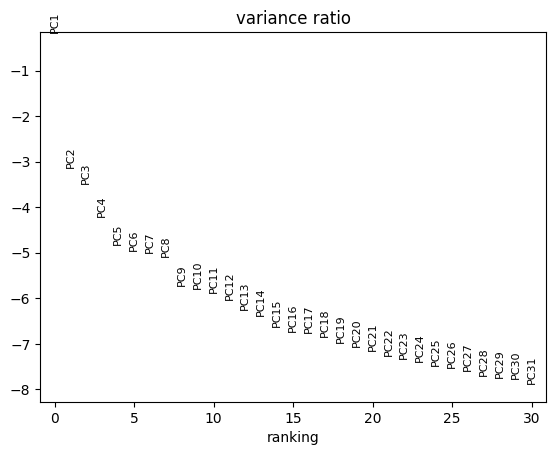

In [5]:
sc.tl.pca(all_adata, n_comps=50)
sc.pl.pca_variance_ratio(all_adata, log=True)


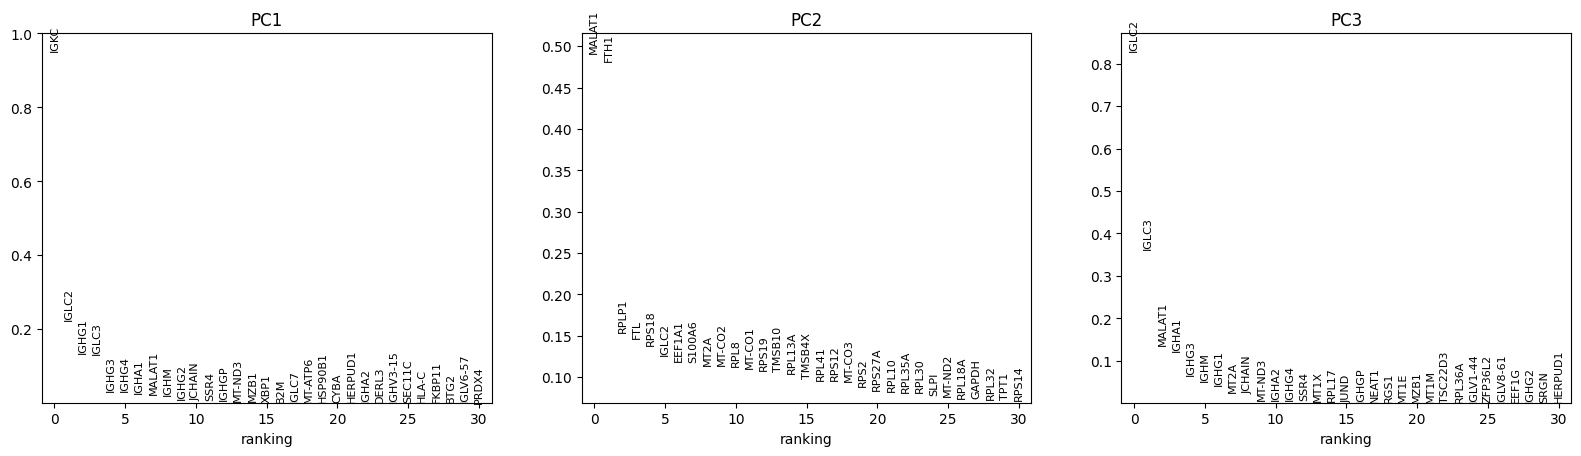

In [6]:
sc.pl.pca_loadings(all_adata, include_lowest=False)


In [7]:
# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


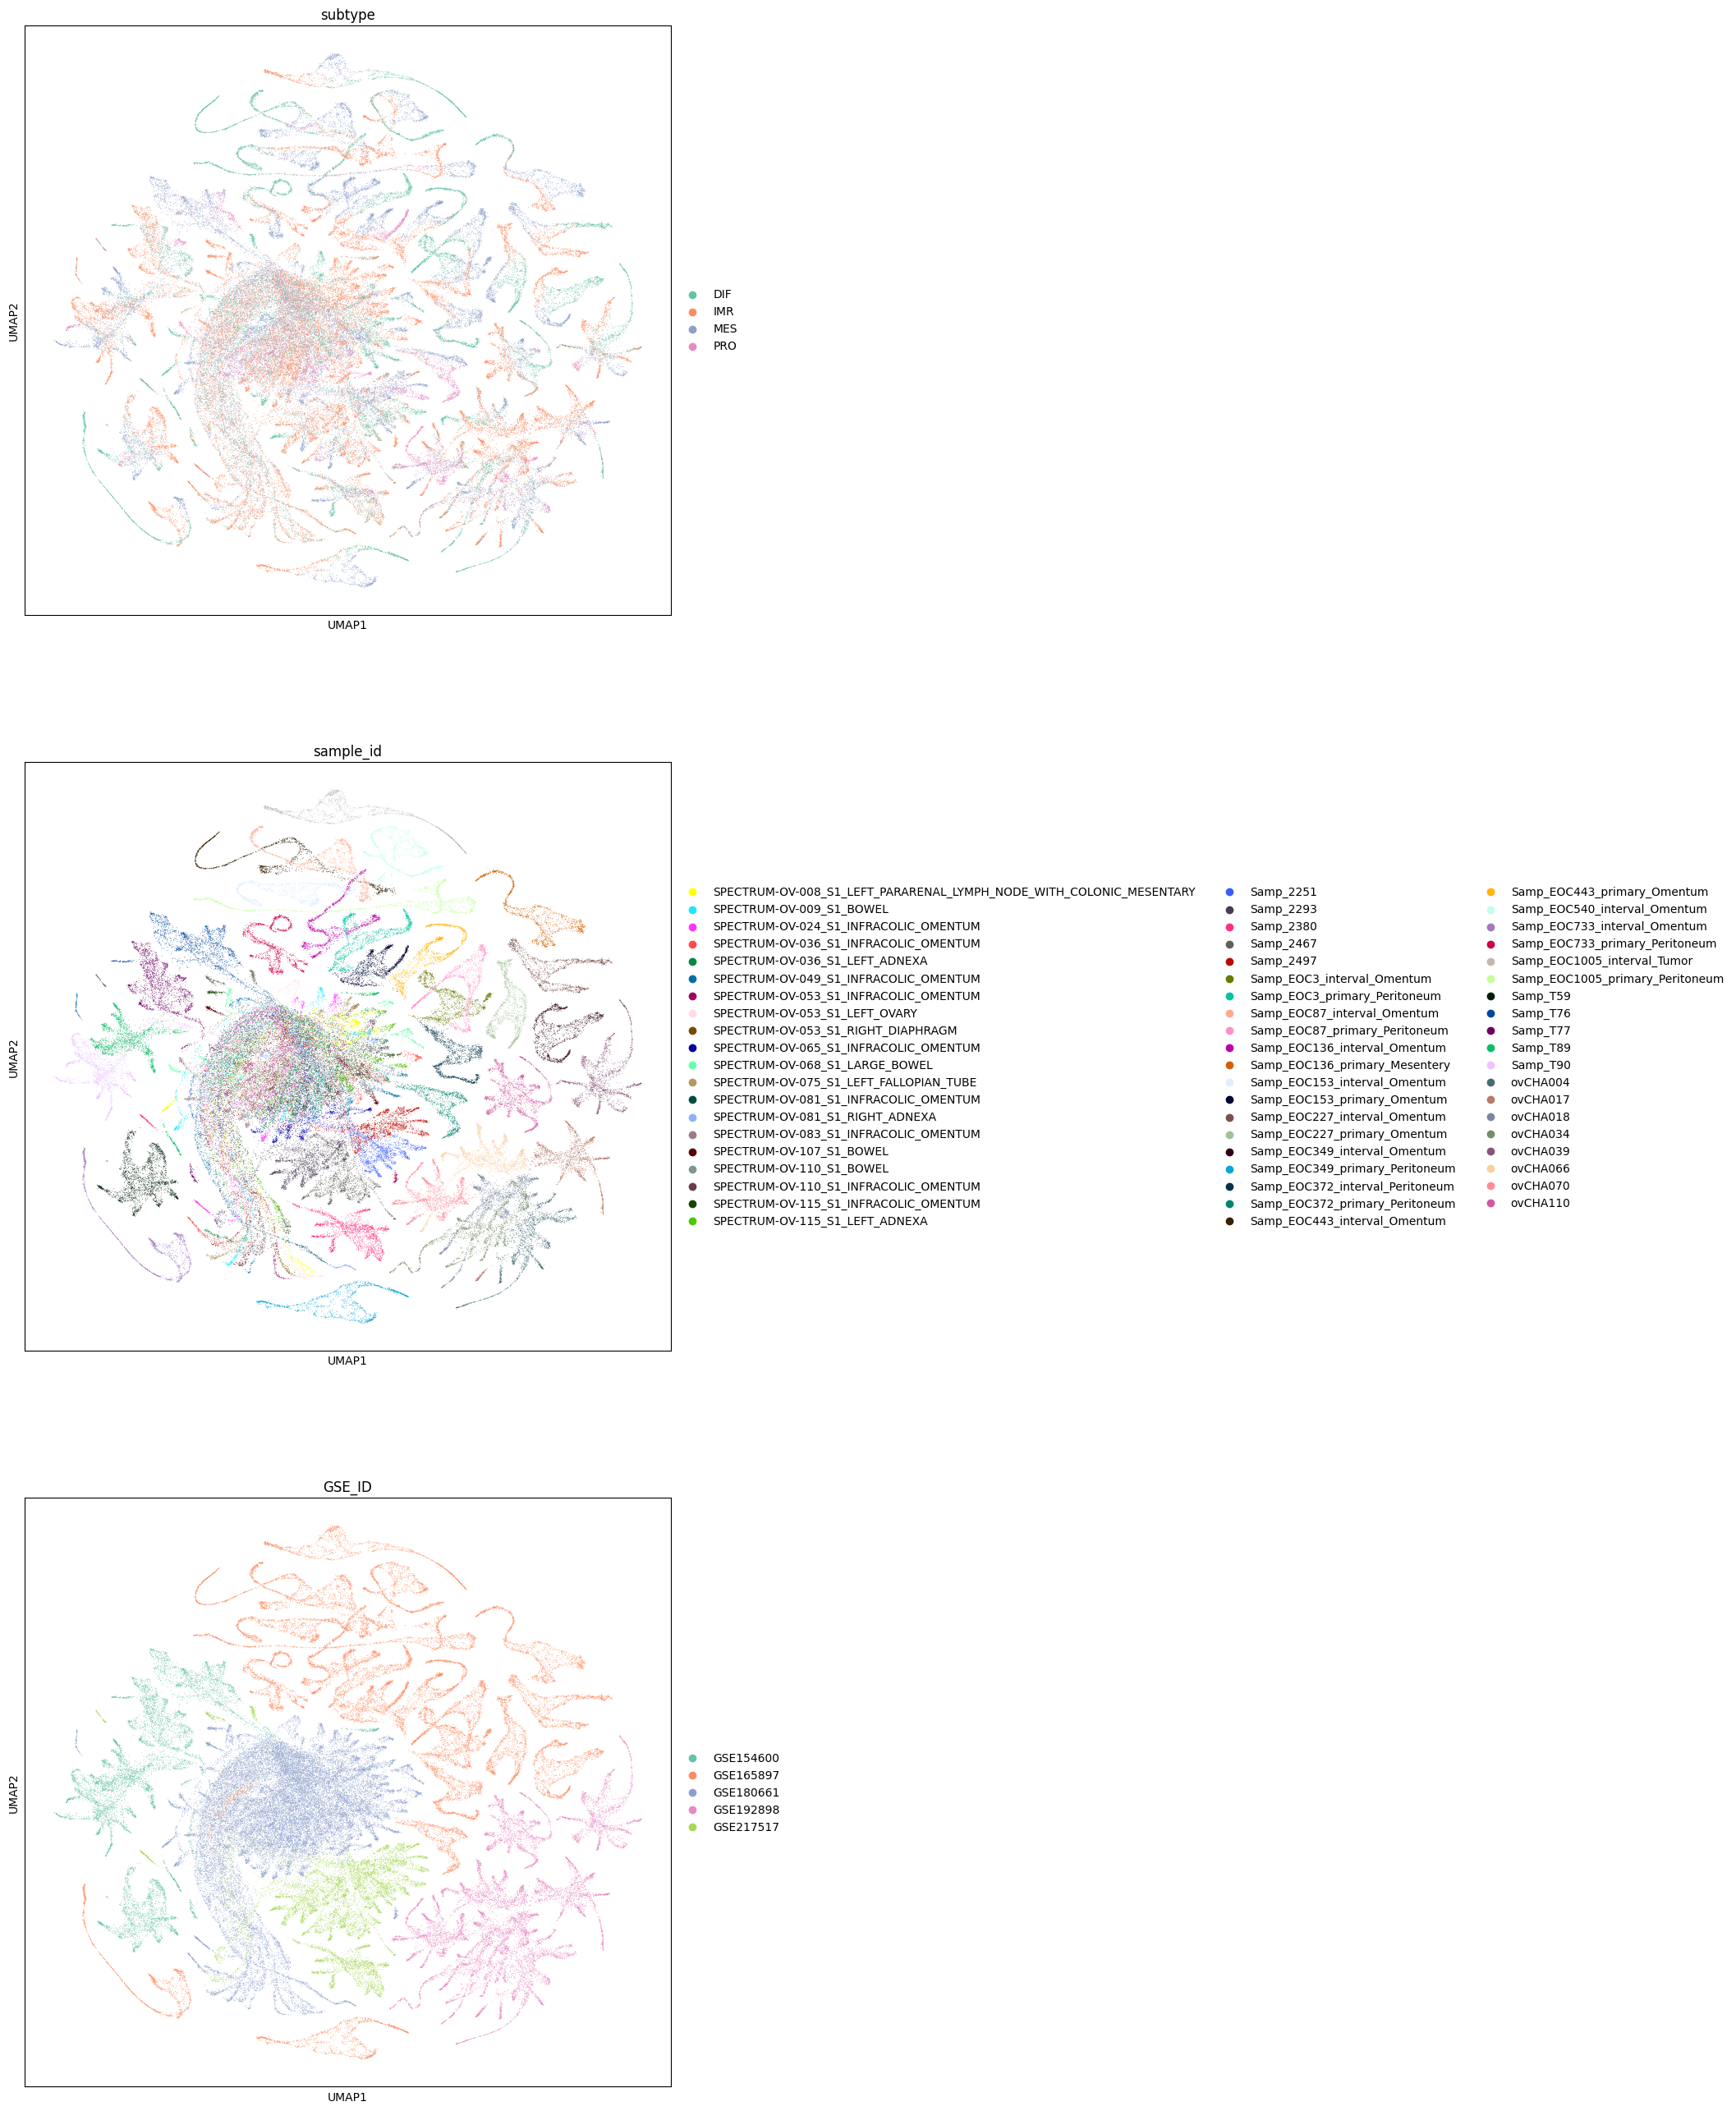

In [8]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color=['subtype', 'sample_id', "GSE_ID"], ncols=1)


In [9]:
tab = all_adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype                                              DIF   IMR   MES  PRO
sample_id                                                                
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WI...   442   931   324    3
SPECTRUM-OV-009_S1_BOWEL                             489   796   401   14
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM                339   781   469  111
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM                264  1108   168  160
SPECTRUM-OV-036_S1_LEFT_ADNEXA                       343   912   332  113
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM                278   734   459  229
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM                367   761   393  179
SPECTRUM-OV-053_S1_LEFT_OVARY                        496   665   397  142
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM                   359   790   343  208
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM                222   473   558  447
SPECTRUM-OV-068_S1_LARGE_BOWEL                       406   782   512    0
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE               281  1057   300   62
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM                434   942   261   63
SPECTRUM-OV-081_S1_RIGHT_ADNEXA                      412   854   386   48
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM                  6   493   499  702
SPECTRUM-OV-107_S1_BOWEL                             269   586   599  246
SPECTRUM-OV-110_S1_BOWEL                             275   778   516  131
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM                132   671   508  389
SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM                310   840   470   80
SPECTRUM-OV-115_S1_LEFT_ADNEXA                       260   753   581  106
Samp_2251                                           1237   383   433   47
Samp_2293                                            290  1584   226    0
Samp_2380                                            678   785   459  178
Samp_2467                                            266  1137   603   94
Samp_2497                                             46   283  1176  595
Samp_EOC3_interval_Omentum                           557   199   544    0
Samp_EOC3_primary_Peritoneum                         468   355   477    0
Samp_EOC87_interval_Omentum                          392   256   520  132
Samp_EOC87_primary_Peritoneum                        440   340   486   34
Samp_EOC136_interval_Omentum                         305   297   675   23
Samp_EOC136_primary_Mesentery                        269   422   608    1
Samp_EOC153_interval_Omentum                         424   417   403   56
Samp_EOC153_primary_Omentum                            2   394   469  435
Samp_EOC227_interval_Omentum                         350   581   357   12
Samp_EOC227_primary_Omentum                          610   397   293    0
Samp_EOC349_interval_Omentum                         571   394   335    0
Samp_EOC349_primary_Peritoneum                       423   380   478   19
Samp_EOC372_interval_Peritoneum                      403   302   551   44
Samp_EOC372_primary_Peritoneum                         2   274   402  622
Samp_EOC443_interval_Omentum                         650   231   419    0
Samp_EOC443_primary_Omentum                          433   365   488   14
Samp_EOC540_interval_Omentum                         449   365   484    2
Samp_EOC733_interval_Omentum                         698   417   185    0
Samp_EOC733_primary_Peritoneum                       518   474   308    0
Samp_EOC1005_interval_Tumor                          587   361   292   60
Samp_EOC1005_primary_Peritoneum                      365   383   333  219
Samp_T59                                             393   933   610  164
Samp_T76                                             153    27  1503  417
Samp_T77                                             742  1061     1  296
Samp_T89                                             365   983   752    0
Samp_T90                                             148  1032   738  182
ovCHA004                                             358   642   812   88
ovCH

In [10]:

idx = np.where(np.logical_and(all_adata.obs.Y_max.isin(stromal_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = all_adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype                                             DIF  IMR  MES  PRO
sample_id                                                             
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WI...   64    3  132    1
SPECTRUM-OV-009_S1_BOWEL                             82    2  105   11
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM                10    1  111   78
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM                17   14   59  110
SPECTRUM-OV-036_S1_LEFT_ADNEXA                       40    1   92   67
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM                 0    3  110   87
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM                 7    1  101   91
SPECTRUM-OV-053_S1_LEFT_OVARY                        17    0   92   91
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM                   10    2   68  120
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM                72    0   96   32
SPECTRUM-OV-068_S1_LARGE_BOWEL                       73    2  125    0
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE               22   16  123   39
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM                59    8   99   34
SPECTRUM-OV-081_S1_RIGHT_ADNEXA                      36    3  122   39
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM                 0    0   98  102
SPECTRUM-OV-107_S1_BOWEL                             17    0  103   80
SPECTRUM-OV-110_S1_BOWEL                              0    1  125   74
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM                 0    0  103   97
SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM                26    2  114   58
SPECTRUM-OV-115_S1_LEFT_ADNEXA                        4    1  121   74
Samp_2251                                            47    0  114   39
Samp_2293                                             8   90  102    0
Samp_2380                                             5    0  107   88
Samp_2467                                             0    1  141   58
Samp_2497                                             0    0  119   81
Samp_EOC3_interval_Omentum                            0    0  100    0
Samp_EOC3_primary_Peritoneum                          0    0  100    0
Samp_EOC87_interval_Omentum                           0    0  100    0
Samp_EOC87_primary_Peritoneum                         0    0  100    0
Samp_EOC136_interval_Omentum                          0    0  100    0
Samp_EOC136_primary_Mesentery                         0    0  100    0
Samp_EOC153_interval_Omentum                          0    0  100    0
Samp_EOC153_primary_Omentum                           0    0  100    0
Samp_EOC227_interval_Omentum                          0    0  100    0
Samp_EOC227_primary_Omentum                           1    0   99    0
Samp_EOC349_interval_Omentum                          0    0  100    0
Samp_EOC349_primary_Peritoneum                        0    0  100    0
Samp_EOC372_interval_Peritoneum                       0    0   98    2
Samp_EOC372_primary_Peritoneum                        0    0  100    0
Samp_EOC443_interval_Omentum                          1    0   99    0
Samp_EOC443_primary_Omentum                           0    0  100    0
Samp_EOC540_interval_Omentum                          0    0  100    0
Samp_EOC733_interval_Omentum                          6    1   93    0
Samp_EOC733_primary_Peritoneum                        0    0  100    0
Samp_EOC1005_interval_Tumor                           0    0  100    0
Samp_EOC1005_primary_Peritoneum                       0    0   98    2
Samp_T59                                             75    3  236   86
Samp_T76                                              0    0  237  163
Samp_T77                                            222   10    1  167
Samp_T89                                             32    2  366    0
Samp_T90                                             12    8  299   81
ovCHA004                                              1    0  128   71
ovCHA017                                              1    1  178   20
ovCHA018                                              4    0    7  189
ovCHA034                

In [11]:

idx = np.where(np.logical_and(all_adata.obs.Y_max.isin(immune_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = all_adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype                                             DIF  IMR  MES  PRO
sample_id                                                             
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WI...   10  286    3    1
SPECTRUM-OV-009_S1_BOWEL                              3  281   16    0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM                 3  276   21    0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM                 0  300    0    0
SPECTRUM-OV-036_S1_LEFT_ADNEXA                        1  298    1    0
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM                 2  275   18    5
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM                 4  288    7    1
SPECTRUM-OV-053_S1_LEFT_OVARY                         7  287    6    0
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM                    4  292    4    0
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM                12  237   40   11
SPECTRUM-OV-068_S1_LARGE_BOWEL                        4  289    7    0
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE                0  299    1    0
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM                12  287    1    0
SPECTRUM-OV-081_S1_RIGHT_ADNEXA                       8  288    4    0
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM                 0  245   39   16
SPECTRUM-OV-107_S1_BOWEL                              9  234   52    5
SPECTRUM-OV-110_S1_BOWEL                              3  280   17    0
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM                 4  272   18    6
SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM                 1  291    8    0
SPECTRUM-OV-115_S1_LEFT_ADNEXA                        2  285   13    0
Samp_2251                                           128  155   17    0
Samp_2293                                             0  300    0    0
Samp_2380                                            42  252    6    0
Samp_2467                                             2  293    5    0
Samp_2497                                             6   81  186   27
Samp_EOC3_interval_Omentum                            4   94    2    0
Samp_EOC3_primary_Peritoneum                          0  100    0    0
Samp_EOC87_interval_Omentum                           1   92    7    0
Samp_EOC87_primary_Peritoneum                         0  100    0    0
Samp_EOC136_interval_Omentum                          0   99    1    0
Samp_EOC136_primary_Mesentery                         0  100    0    0
Samp_EOC153_interval_Omentum                          0  100    0    0
Samp_EOC153_primary_Omentum                           0  100    0    0
Samp_EOC227_interval_Omentum                          0  100    0    0
Samp_EOC227_primary_Omentum                           0  100    0    0
Samp_EOC349_interval_Omentum                          1   99    0    0
Samp_EOC349_primary_Peritoneum                        0   99    1    0
Samp_EOC372_interval_Peritoneum                       0  100    0    0
Samp_EOC372_primary_Peritoneum                        0   97    2    1
Samp_EOC443_interval_Omentum                          2   96    2    0
Samp_EOC443_primary_Omentum                           0  100    0    0
Samp_EOC540_interval_Omentum                          1   98    1    0
Samp_EOC733_interval_Omentum                          0  100    0    0
Samp_EOC733_primary_Peritoneum                        0  100    0    0
Samp_EOC1005_interval_Tumor                           1   99    0    0
Samp_EOC1005_primary_Peritoneum                       0  100    0    0
Samp_T59                                             19  568   13    0
Samp_T76                                              6   18  569    7
Samp_T77                                             74  526    0    0
Samp_T89                                             28  550   22    0
Samp_T90                                              9  556   35    0
ovCHA004                                             44  411  145    0
ovCHA017                                              7  555   36    2
ovCHA018                                             75  508   17    0
ovCHA034                

In [12]:

idx = np.where(np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = all_adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype                                             DIF  IMR  MES  PRO
sample_id                                                             
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WI...   99    1    0    0
SPECTRUM-OV-009_S1_BOWEL                            100    0    0    0
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM               100    0    0    0
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM               100    0    0    0
SPECTRUM-OV-036_S1_LEFT_ADNEXA                      100    0    0    0
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM                96    0    0    4
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM               100    0    0    0
SPECTRUM-OV-053_S1_LEFT_OVARY                       100    0    0    0
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM                  100    0    0    0
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM                 0    0    0  100
SPECTRUM-OV-068_S1_LARGE_BOWEL                       99    1    0    0
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE              100    0    0    0
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM               100    0    0    0
SPECTRUM-OV-081_S1_RIGHT_ADNEXA                     100    0    0    0
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM                 0    0    0  100
SPECTRUM-OV-107_S1_BOWEL                             86    0    0   14
SPECTRUM-OV-110_S1_BOWEL                            100    0    0    0
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM                57    0    0   43
SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM               100    0    0    0
SPECTRUM-OV-115_S1_LEFT_ADNEXA                       99    0    1    0
Samp_2251                                           100    0    0    0
Samp_2293                                           100    0    0    0
Samp_2380                                           100    0    0    0
Samp_2467                                           100    0    0    0
Samp_2497                                             0    0    0  100
Samp_EOC3_interval_Omentum                          100    0    0    0
Samp_EOC3_primary_Peritoneum                        100    0    0    0
Samp_EOC87_interval_Omentum                         100    0    0    0
Samp_EOC87_primary_Peritoneum                       100    0    0    0
Samp_EOC136_interval_Omentum                        100    0    0    0
Samp_EOC136_primary_Mesentery                        98    1    1    0
Samp_EOC153_interval_Omentum                        100    0    0    0
Samp_EOC153_primary_Omentum                           0    0    0  100
Samp_EOC227_interval_Omentum                        100    0    0    0
Samp_EOC227_primary_Omentum                         100    0    0    0
Samp_EOC349_interval_Omentum                        100    0    0    0
Samp_EOC349_primary_Peritoneum                      100    0    0    0
Samp_EOC372_interval_Peritoneum                     100    0    0    0
Samp_EOC372_primary_Peritoneum                        0    0    0  100
Samp_EOC443_interval_Omentum                        100    0    0    0
Samp_EOC443_primary_Omentum                         100    0    0    0
Samp_EOC540_interval_Omentum                        100    0    0    0
Samp_EOC733_interval_Omentum                        100    0    0    0
Samp_EOC733_primary_Peritoneum                      100    0    0    0
Samp_EOC1005_interval_Tumor                         100    0    0    0
Samp_EOC1005_primary_Peritoneum                      98    0    0    2
Samp_T59                                             99    0    0    1
Samp_T76                                             85    0    0   15
Samp_T77                                            100    0    0    0
Samp_T89                                            100    0    0    0
Samp_T90                                             58    2    0   40
ovCHA004                                            100    0    0    0
ovCHA017                                             92    0    0    8
ovCHA018                                            100    0    0    0
ovCHA034                

# Do DE

In [13]:
# set the label

cell_type_vec = np.array(["DIF_total"]*all_adata.obs.sample_id.shape[0])
pro_label_idx = np.where(all_adata.obs.sample_id.isin(["ovCHA070", "Samp_EOC372_primary_Peritoneum",
                                                   "Samp_EOC153_primary_Omentum", "Samp_2497",
                                                   "SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM",
                                                   "SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

all_adata.obs['subtype_total'] = cell_type_vec



In [14]:
idx = np.where(np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = all_adata.obs.iloc[idx].groupby(['subtype_total', 'subtype']).size()
tab.unstack()

subtype         DIF  IMR  MES  PRO
subtype_total                     
DIF_total      5115    5    2  178
PRO_total         0    0    0  600

In [15]:
# normalize to 10K counts per cell
sc.pp.normalize_total(all_adata, target_sum=1e6)

# log data
sc.pp.log1p(all_adata)

# scale the genes
sc.pp.scale(all_adata, max_value=10)

# calculate PCA
sc.tl.pca(all_adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


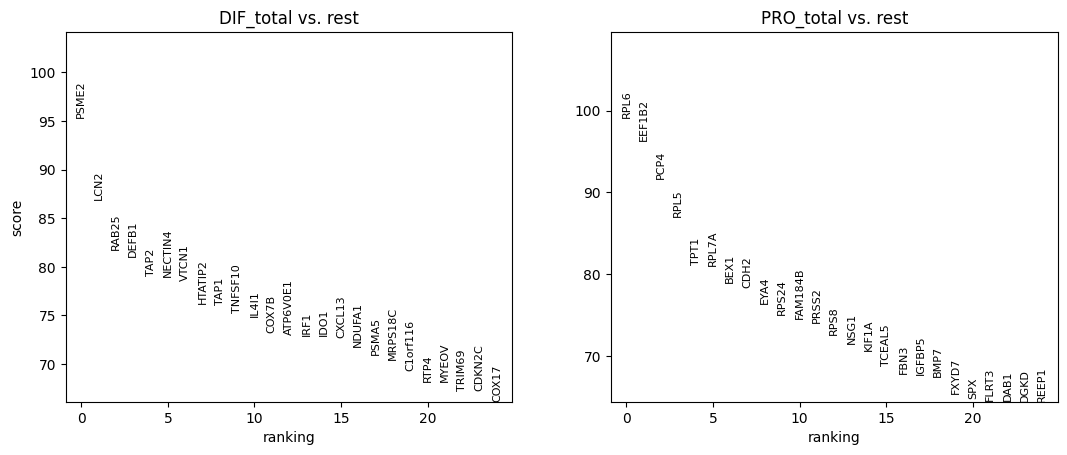

In [16]:
sc.tl.rank_genes_groups(all_adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(all_adata, n_genes=25, sharey=False, key="wilcoxon")

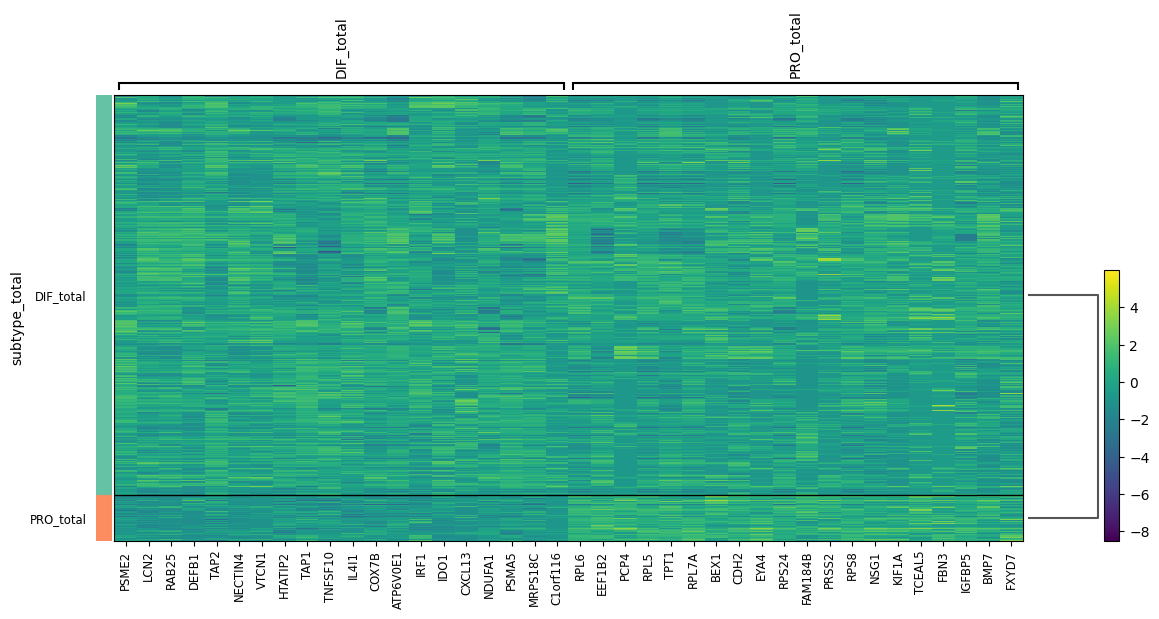

In [17]:
sc.pl.rank_genes_groups_heatmap(all_adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


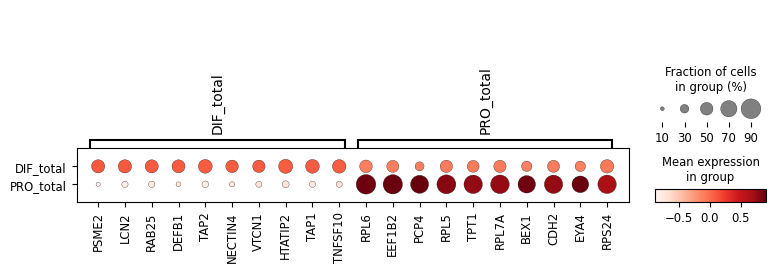

In [18]:
sc.pl.rank_genes_groups_dotplot(all_adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


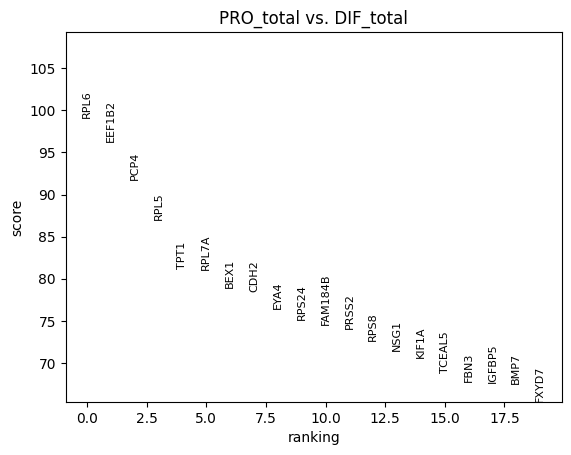

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


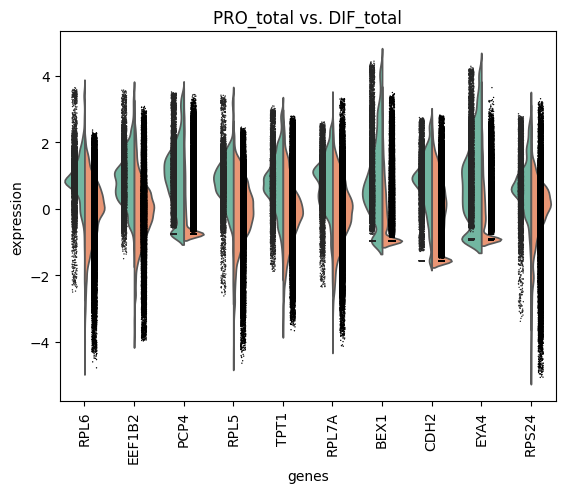

In [19]:
sc.tl.rank_genes_groups(all_adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(all_adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(all_adata, groups='PRO_total', n_genes=10)


In [20]:
wc = all_adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['RPL6', 'EEF1B2', 'PCP4', 'RPL5', 'TPT1', 'RPL7A', 'BEX1', 'CDH2',
       'EYA4', 'RPS24', 'FAM184B', 'PRSS2', 'RPS8', 'NSG1', 'KIF1A',
       'TCEAL5', 'FBN3', 'IGFBP5', 'BMP7', 'FXYD7', 'SPX', 'FLRT3',
       'DAB1', 'DGKD', 'REEP1', 'RPL18', 'SMARCE1', 'MLXIPL', 'PRSS1',
       'EBF4', 'PLCB4', 'EMID1', 'ITIH5', 'TTYH1', 'UPK3B', 'COL9A2',
       'EIF4B', 'AREG', 'SSH2', 'PCSK1N', 'NACA', 'DSC3', 'SOX11',
       'ADGRG2', 'FGF19', 'RPS23', 'COL4A6', 'NTNG1', 'BEND5', 'LRRN1',
       'PTCHD1', 'BZW1', 'RPL11', 'SMO', 'ZNF711', 'SP5', 'PIANP',
       'ACSM3', 'WLS', 'TCF7L1', 'PRCD', 'SCG5', 'GRIN2A', 'ICA1L',
       'LINC01139', 'LINC00667', 'LAMP5', 'MFAP2', 'SFRP2', 'SYNDIG1',
       'ILF3', 'COMP', 'PLXNA4', 'TNNT1', 'GXYLT2', 'ANGPTL1', 'TSPAN2',
       'NGEF', 'SH3BP4', 'ZNF846', 'GNAZ', 'GRIK5', 'IRS1', 'KCNMB2',
       'PTBP2', 'RPL9', 'RPS3A', 'PHOX2A', 'SLC6A13', 'CNKSR2', 'GOLIM4',
       'IGLON5', 'GPC2', 'DTNA', 'DNAH7', 'PLEKHG4B', 'RAB11FIP2',
       'COL9A3', 'S

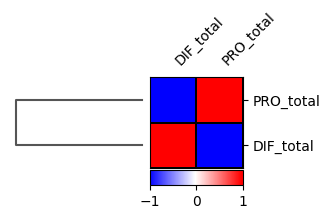

In [21]:
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, all_adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(all_adata[idx], groupby="subtype_total")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


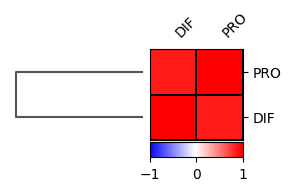

In [22]:
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, all_adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(all_adata[idx], groupby="subtype")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


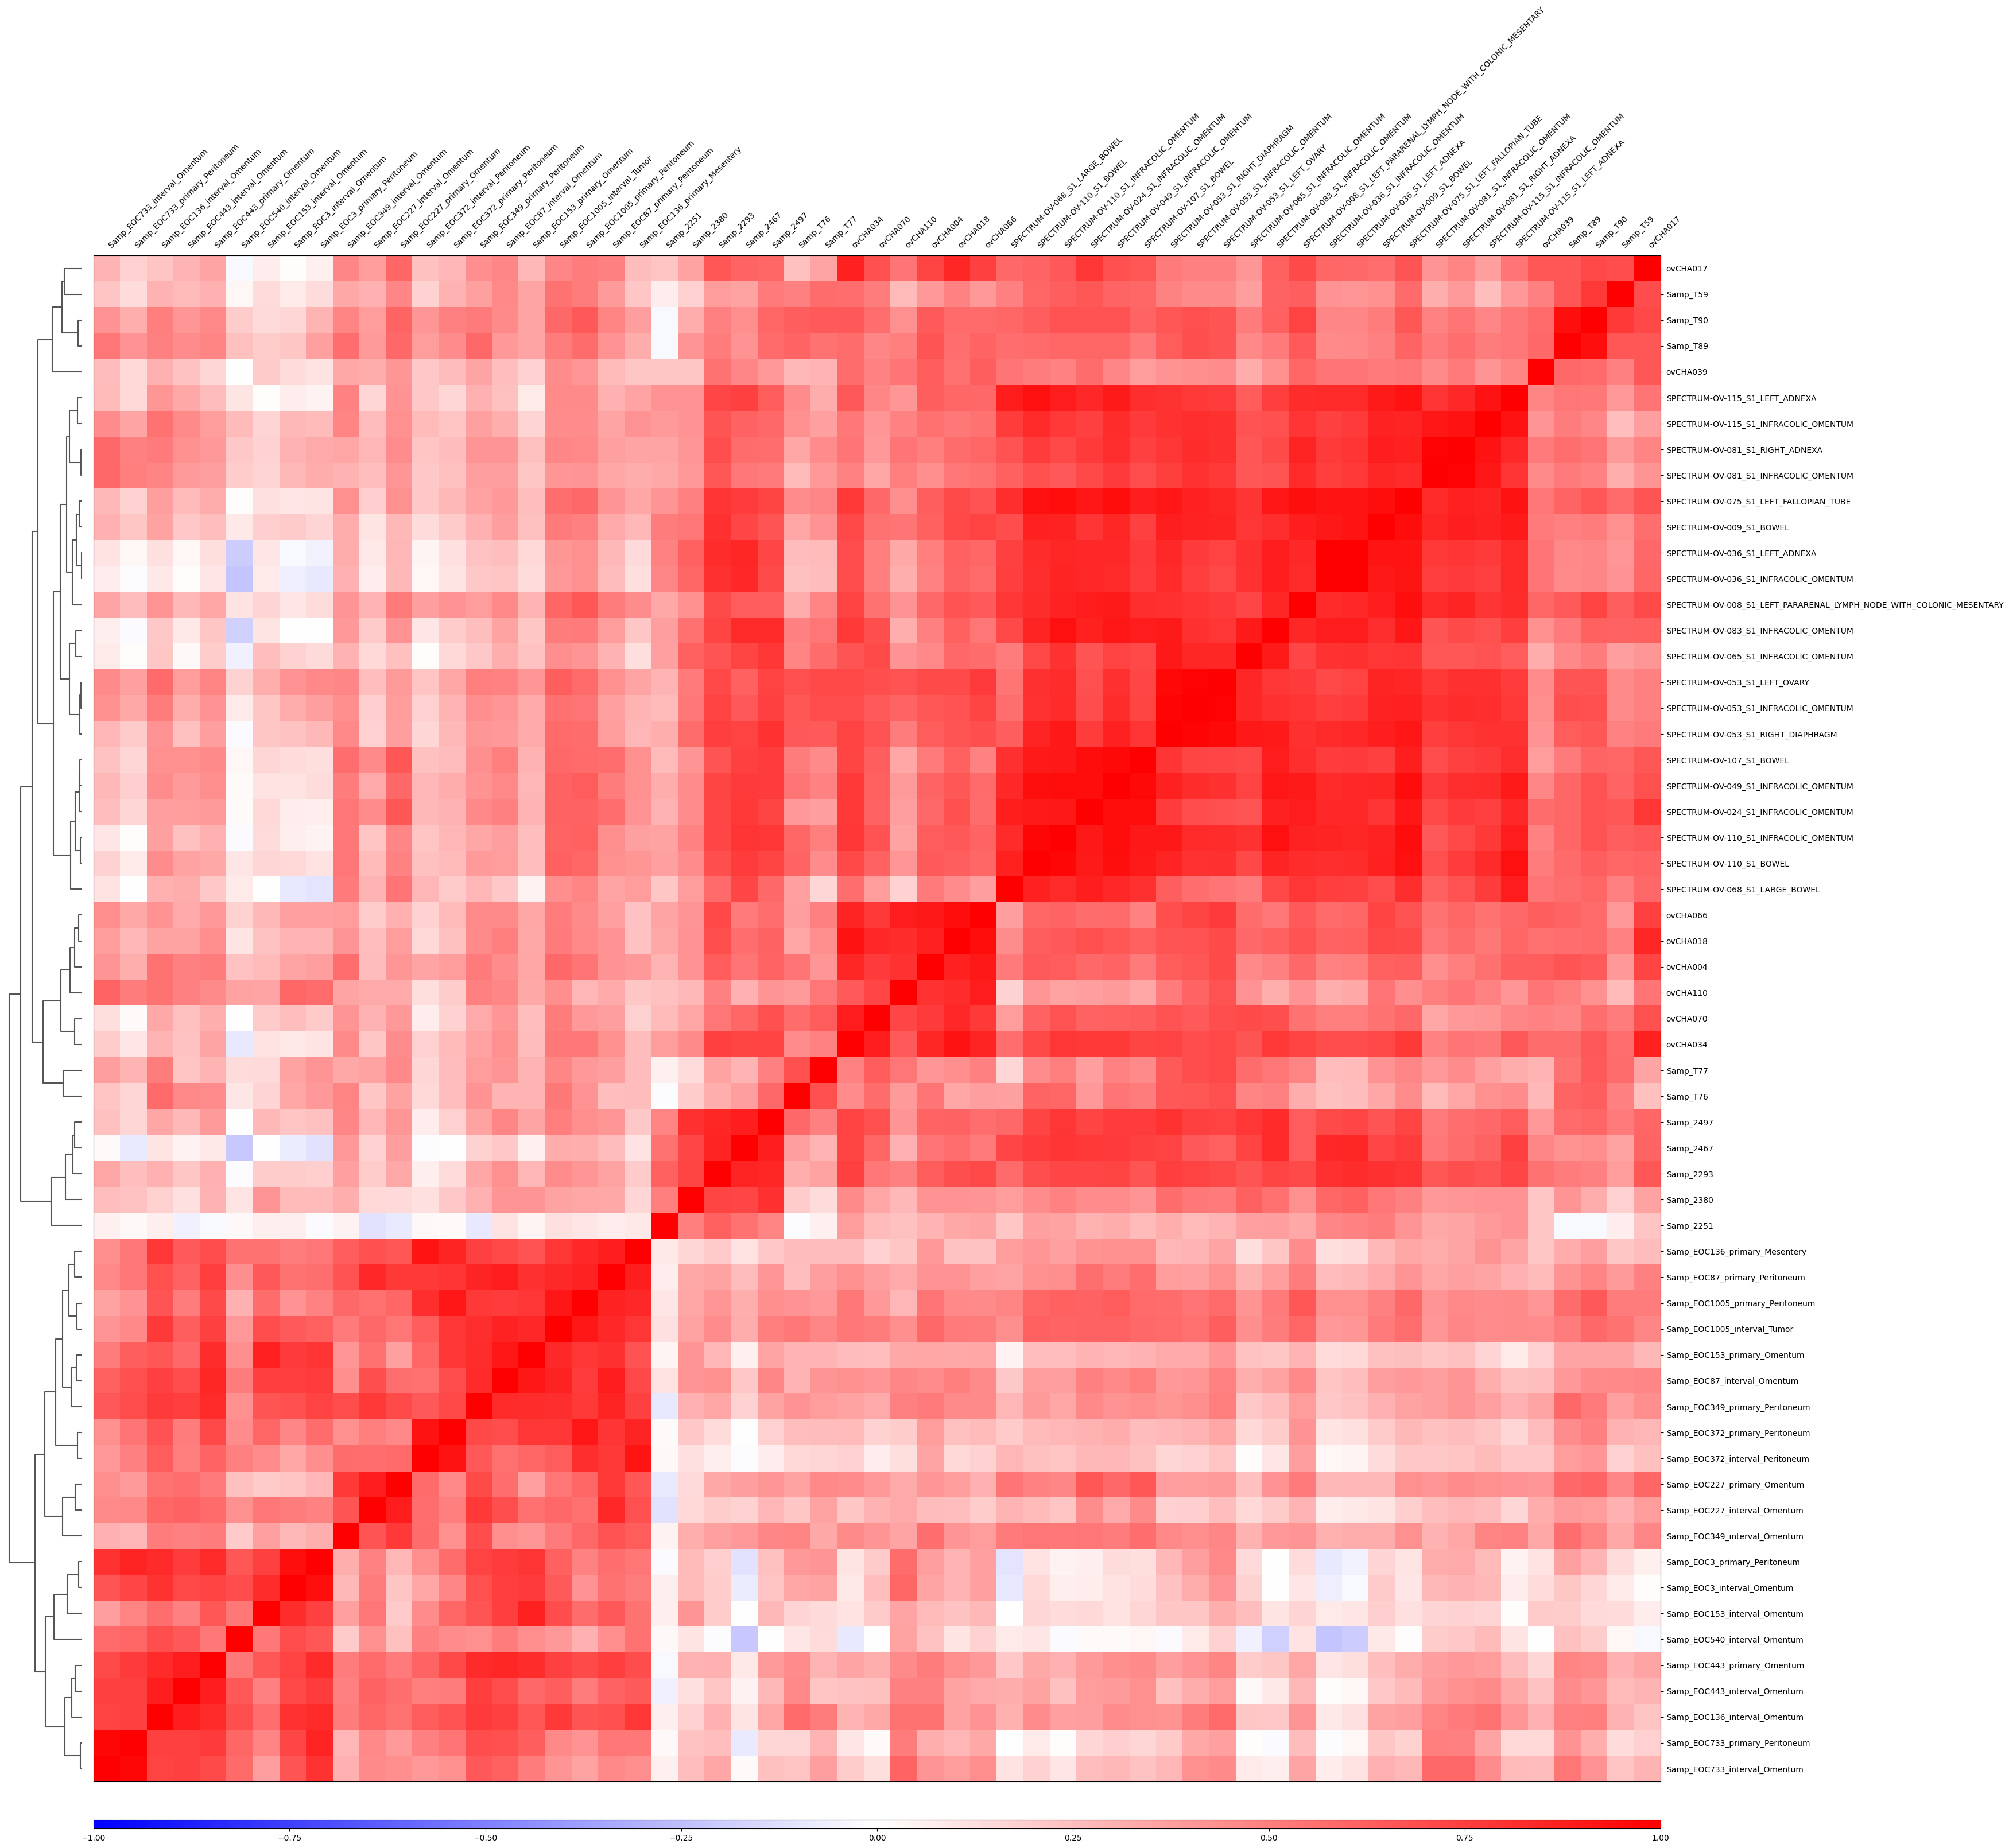

In [23]:
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, all_adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(all_adata[idx, wc[0:100]], groupby="sample_id")

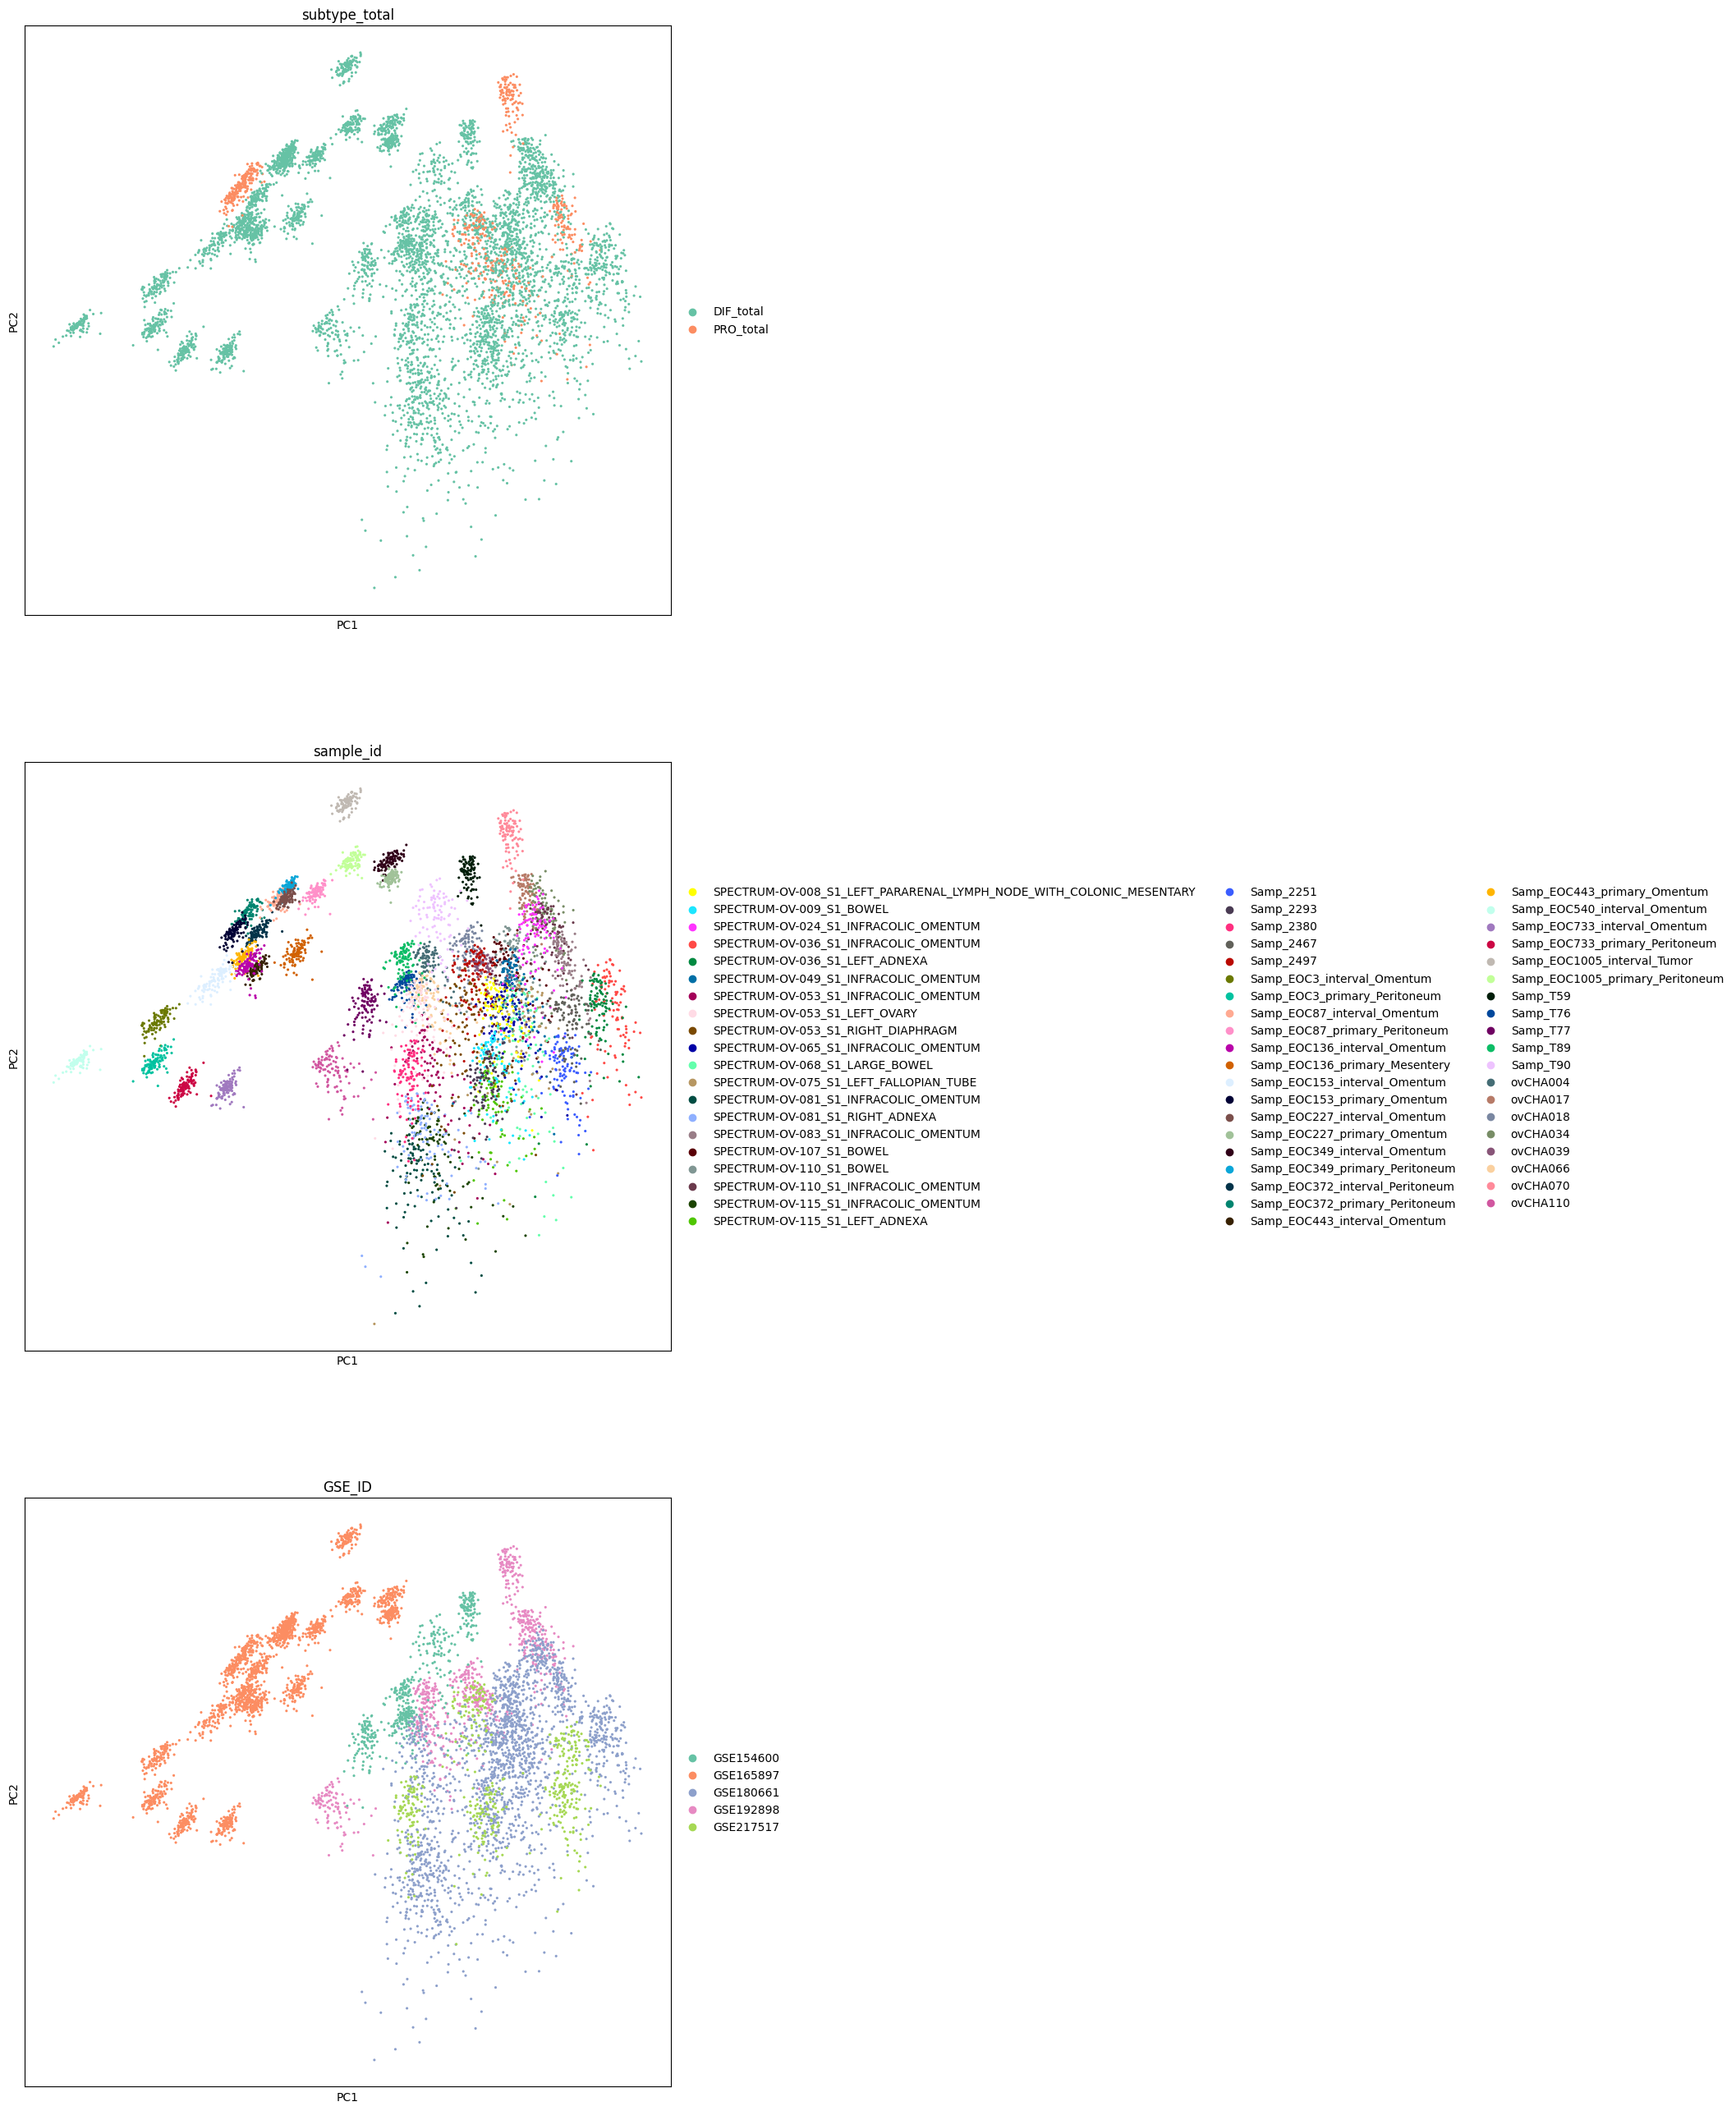

In [24]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    idx = np.logical_and(all_adata.obs.Y_max.isin(tumor_cell_ids), all_adata.obs.cell_prop_type == "cell_type_specific") 
    sc.pl.pca(all_adata[idx,wc[0:100]], color=['subtype_total', 'sample_id', "GSE_ID"], ncols=1)


# make predictor

Y         ID
0     0  GSE192898
1     0  GSE192898
2     0  GSE192898
3     0  GSE192898
4     0  GSE192898
...  ..        ...
9395  1  GSE217517
9396  1  GSE217517
9397  1  GSE217517
9398  1  GSE217517
9399  1  GSE217517

[38000 rows x 2 columns]

In [116]:
from sklearn.model_selection import StratifiedKFold

pred_ad = all_adata[np.where(np.logical_and(all_adata.obs.cell_prop_type == "random", all_adata.obs.sample_id != "Samp_EOC153_primary_Omentum"))[0]]

X_val = pred_ad.X
Y_val = pred_ad.obs.subtype_total
Y_val_num = [int(x == "PRO_total") for x in np.asarray(Y_val)]


X_train, X_test, y_train, y_test = train_test_split(X_val, Y_val_num,
                                                    test_size=0.2,
                                                    random_state = 42,
                                                    stratify = Y_val_num)
len(X_train), len(X_test), len(y_train), len(y_test), set(y_test)


(31200, 7800, 31200, 7800, {0, 1})

In [105]:

# model = RandomForestClassifier()

# param_grid = {
#     'n_estimators': [10, 20, 50],
#     'max_features': [0.01, 0.05, 0.1, 0.25, 0.5],
#     'max_depth': [3, 4, 5]
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')  # Or another scoring metric
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

# final_model = RandomForestClassifier(**grid_search.best_params_)  # Or random_search.best_params_
# final_model.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
final_model = RandomForestClassifier(n_estimators=10, max_features=0.1, max_depth=3)
final_model.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      7000
           1       1.00      0.76      0.86       800

    accuracy                           0.97      7800
   macro avg       0.99      0.88      0.92      7800
weighted avg       0.98      0.97      0.97      7800

0.8603988603988604
[[7000    0]
 [ 196  604]]


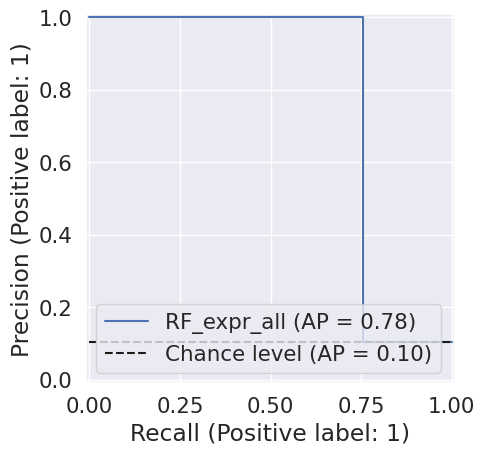

In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_predict = final_model.predict(X_test)
print(classification_report(y_test, model_predict))
print(f1_score(y_test, model_predict))
print(confusion_matrix(y_test, model_predict))
precision, recall, thresholds = precision_recall_curve(
    y_test, model_predict)


display = PrecisionRecallDisplay.from_predictions(
    y_test, model_predict, name="RF_expr_all", plot_chance_level=True
)


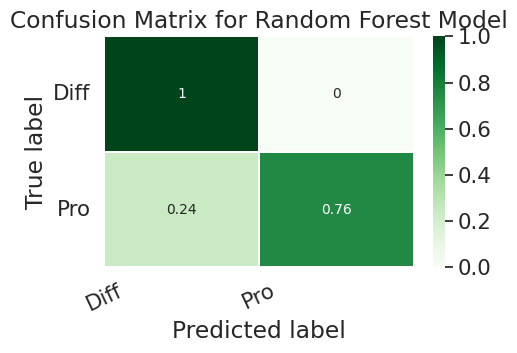

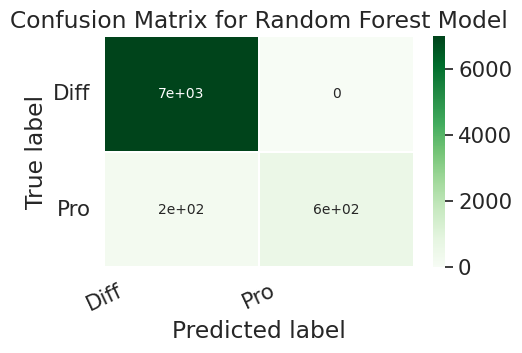

In [120]:
conf_matr = confusion_matrix(y_test, model_predict)

conf_matr = conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(5,3))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Diff', 'Pro']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


conf_matr = confusion_matrix(y_test, model_predict)

# Build the plot
plt.figure(figsize=(5,3))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Diff', 'Pro']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     30600
           1       0.00      0.00      0.00      3400

    accuracy                           0.90     34000
   macro avg       0.45      0.50      0.47     34000
weighted avg       0.81      0.90      0.85     34000

0.0
[[30595     5]
 [ 3400     0]]


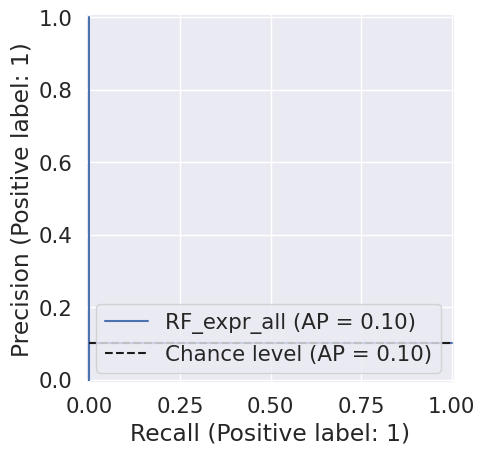

In [121]:
heldout_ad = all_adata[np.where(all_adata.obs.GSE_ID == "GSE180661")[0]]

X_heldout = heldout_ad.X
Y_heldout = heldout_ad.obs.subtype_total
Y_heldout_num = [int(x == "PRO_total") for x in np.asarray(Y_heldout)]


model_predict = final_model.predict(X_heldout)
print(classification_report(Y_heldout_num, model_predict))
print(f1_score(Y_heldout_num, model_predict))
print(confusion_matrix(Y_heldout_num, model_predict))
precision, recall, thresholds = precision_recall_curve(
    Y_heldout_num, model_predict)


display = PrecisionRecallDisplay.from_predictions(
    Y_heldout_num, model_predict, name="RF_expr_all", plot_chance_level=True
)


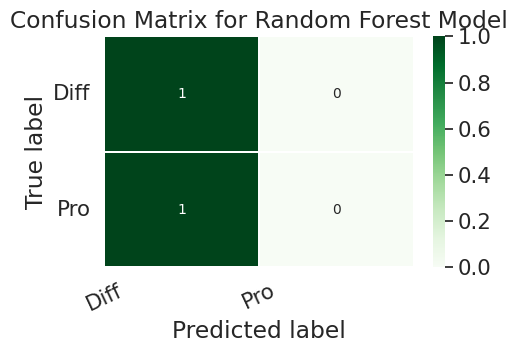

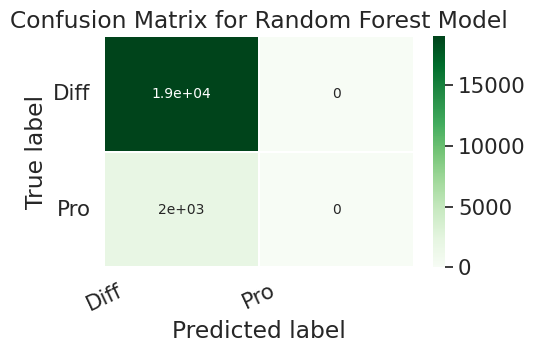

In [110]:
conf_matr = confusion_matrix(Y_heldout_num, model_predict)

conf_matr = conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(5,3))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Diff', 'Pro']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


conf_matr = confusion_matrix(Y_heldout_num, model_predict)

# Build the plot
plt.figure(figsize=(5,3))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Diff', 'Pro']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()